# Dynamic Analysis
In this notebook I plan to redo the whole path of experiments and create clean data that will be used as final results. Voltage on power source is set to 11.4V as that is the same as what batteries provide. Batbot weight 606.8g (5.95N)

In [9]:
import matplotlib.pyplot as plt
from utils import *
import numpy as np
import plotly.express as px
import pandas as pd
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [10]:
!python -m serial.tools.list_ports
daq_port = '/dev/ttyUSB0'
command_port = "/dev/ttyACM0"

/dev/ttyACM0        
/dev/ttyUSB0        
2 ports found


In [4]:
measurements = read_measurements_df_6axis(port=daq_port, duration=5)
measurements.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/todo.csv', index=False)

## Unit Correction
I will find the correct units of the measurements obtained and converted to N and N*m.

### Force
Added 399.8g (3.92N) on the structure and then removed it

<Axes: xlabel='Time'>

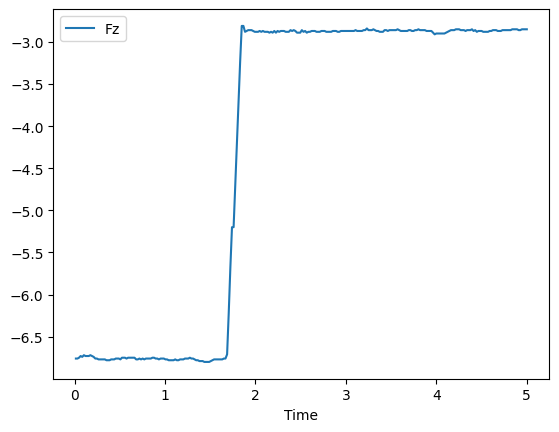

In [5]:
measurements = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/force_unit.csv')
measurements.plot(x='Time', y='Fz')

In [6]:
loaded = measurements[(measurements.Time<1)&(measurements.Time>0.5)].mean().Fz
unloaded = measurements[(measurements.Time<4.5)&(measurements.Time>4)].mean().Fz
measured_force = loaded - unloaded  #  measured for 399.8g
measured_force

-3.8871428571428566

measured forces needs to be divided by 100 to obtain Newtons

### Torque
Added 399.8g (3.92N) at 13.5cm from x axis (0.5292Nm) then removed it.

<Axes: xlabel='Time'>

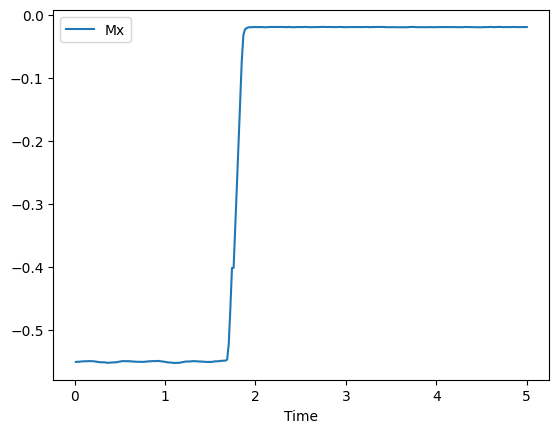

In [7]:
measurements = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/torque_unit.csv')
measurements.plot(x='Time', y='Mx')

In [8]:
loaded = measurements[(measurements.Time<1)&(measurements.Time>0.5)].mean().Mx
unloaded = measurements[(measurements.Time<4)&(measurements.Time>3.5)].mean().Mx
measured_torque = loaded - unloaded  #  measured for 399.8g
measured_torque

-0.5303142857142857

measured torque most be divided by 10000 to get Nm

(Note: changes were then made in the function read_measurements_df_6axis())

## Hovering Angle
I will position the legs in their neutral state and keep them static and find the direction of the average force generated by the wings. The movements of the legs will later on be used to control the Batbot to the hovering position found. Thanks to experiments done before, I realized that the average force increases in the same direction with increasing flapping frequency, so I will use the average force direction as the new upward direction instead of only using the highest force for that as done before.

### Calibration
First  I will calibrate the sensor putting the legs in neutral state and the wings folded (convention from now on).

In [0]:
measurements = read_measurements_df_6axis(port=daq_port, duration=5)
measurements['Time'] = 0
calib = measurements.mean()

In [61]:
calib.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/calib.csv')

In [3]:
calib = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/calib.csv', index_col=0).iloc[:,0]

In [4]:
calib

Time       0.000000
Fx       272.982456
Fy       253.049123
Fz      -839.978947
Mx     -2014.680702
My       187.522807
Mz       990.266667
Name: 0, dtype: float64

### Average Force
The values of the parameters are calculated based on the following configurations:

Desired:
leg_y = 90
leg_y_amplitude = 0
leg_x = 40  
leg_x_amplitude = 0
ellipse_angle = 1
motor = 270

Mapping when using command_batbot_V2():
motor = np.interp(motor, [0, 1], [260, 270])
leg_x = np.interp(leg_x, [0, 1], [40, 120])
leg_y = np.interp(leg_y, [0, 1], [30, 150])
leg_x_amplitude = np.interp(leg_x_amplitude, [0, 1], [0, 40])
leg_y_amplitude = np.interp(leg_y_amplitude, [0, 1], [0, 60])

In [68]:
motor = 1  # 270
leg_x = 0  # 40
leg_y = 0.5  # 90
leg_y_amplitude = 0  # 0
leg_x_amplitude = 0  # 0
ellipse_angle = 1  # Irrelevant
cmd = (motor, leg_x, leg_y, leg_x_amplitude, leg_y_amplitude, ellipse_angle)
command_batbot_V2(cmd, command_port)
time.sleep(1)  # To allow the Batbot to reach the attack angle and flapping speed
#measurements = read_measurements_df_6axis(port=daq_port, duration=5) - calib
measurements.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/hovering_angle.csv', index=False)

Sending command to batbot leg_x: 40.0
leg_y: 90.0
leg_x_amplitude: 0.0
leg_y_amplitude: 0.0
Ellipse: 1
Sent!


<Axes: xlabel='Time'>

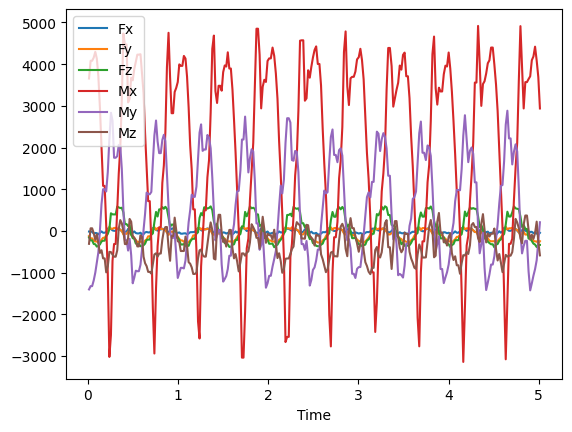

In [5]:
measurements = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/hovering_angle.csv')
measurements.plot(x='Time')

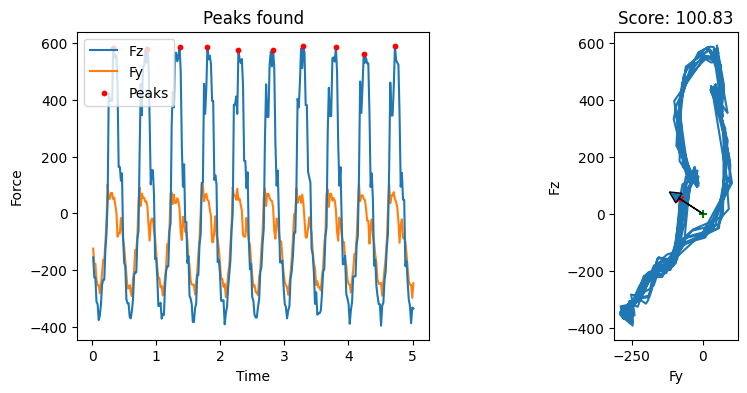

100.82521608529407

In [9]:
fitness_avg_force(measurements, plot=True, args={'peak_height':0, 'peak_distance':10})

In [17]:
a = einheit[einheit.Time<1].mean().Fz
b = einheit[(einheit.Time<6)&(einheit.Time>5)].mean().Fz
a-b7

In [22]:
einheit[['Fz', 'Fx', 'Fy']] = einheit[['Fz', 'Fx', 'Fy']]/100

In [23]:
einheit[['Fz', 'Fx', 'Fy']]

,Fz,Fx,Fy
0,-8.75,2.56,2.50
1,-8.75,2.57,2.50
2,-8.74,2.56,2.50
3,-8.74,2.57,2.50
4,-8.74,2.58,2.50
...,...,...,...
573,-12.65,2.63,2.49
574,-12.65,2.62,2.49
575,-12.65,2.62,2.49
576,-12.65,2.62,2.49
